In [76]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
from scipy import interpolate

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [77]:
%cd /archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle3
%cd gfdl.ncrc4-intel16-prod/pp/ocean_annual_z_d2/
fs=xr.open_dataset('ocean_annual_z_d2.static.nc')
deptho=fs['deptho'][:,:]
lon=fs['geolon']; lat=fs['geolat']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
#print(fs)
%cd av/annual_5yr

/arch2/rnd/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle3
/arch2/rnd/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle3/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z_d2
/arch2/rnd/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle3/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z_d2/av/annual_5yr


In [78]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)



In [79]:
lonr=rebin(np.array(lon),(1120,1440))
latr=rebin(np.array(lat),(1120,1440))


In [81]:
data=xr.open_mfdataset('ocean_annual_z_d2.2003-2007.ann.nc')['time']
title=str(data[0].values); 
print(title)
yearly = xr.open_mfdataset(['ocean_annual_z_d2.2003-2007.ann.nc'])
fhist=yearly


#The above 4 components should add up to net_surface_heating, 'hfds' diagnostic: 
heat   = fhist.variables['boundary_forcing_heat_tendency'][0,0,:,:]
salt   = fhist.variables['boundary_forcing_salt_tendency'][0,0,:,:] #"Surface ocean heat flux from SW+LW+latent+sensible+masstransfer+frazil"
SSS_PSU= fhist.variables['so'][0,0,:,:]
SST    = fhist.variables['thetao'][0,0,:,:]
Pressure = SST *0.0



2005-07-02 00:00:00


In [84]:
SSS = SA_from_SP(SSS_PSU,Pressure,lonr,latr) #absolute salinity g/kg
pot_rho_1 = sigma1(SSS, SST) #potential density referenced to 1000dbar
haline_contraction = beta(SSS, SST, Pressure) #kg/g
salt_transformation = haline_contraction*SSS*salt #*31.0 #last integer is days per month
thermal_expansion = alpha(SSS, SST, Pressure)
heat_transformation =  thermal_expansion*heat #*days per month?

c_p = 3992.1
SURFACE_heat_transf=-heat_transformation/c_p; #units of kg/(s*m2)
SURFACE_salt_transf=-salt; #units of kg/(s*m2)
#np.nanmean(heat_transformation)

In [85]:
print('done')

done


In [42]:
# lon=np.array(lon)
# lat=np.array(lat)
# lon.shape
# #HOW TO MASK
# topo = lat*0.
# topo[np.isnan(net_surface_heating)]=1
# net_surface_heating[(lat>80)]=np.nan
# #net_surface_heating[lat>70]=0.0

In [86]:
heat_transformation.shape

(1120, 1440)

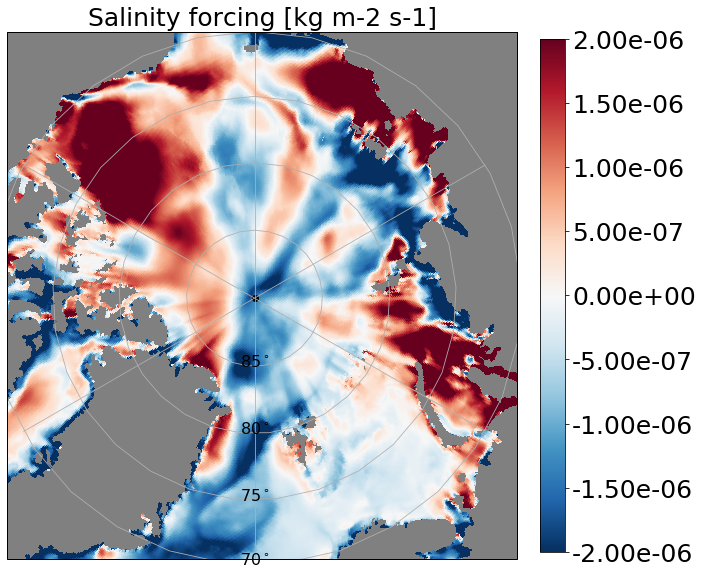

In [88]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lonr, latr,np.ones((1120,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
plt.pcolormesh(lonr, latr,-salt,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-2e-6,vmax=2.e-6);

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Salinity forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')



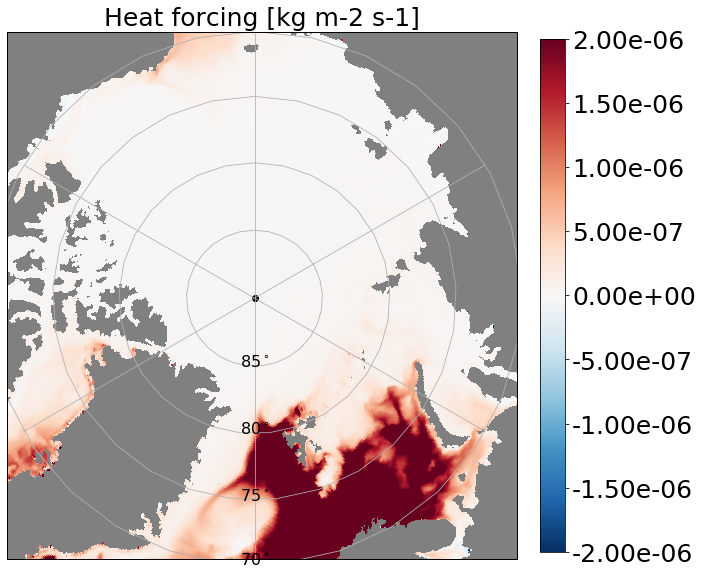

In [71]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lonr, latr,np.ones((1120,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
plt.pcolormesh(lonr, latr,SURFACE_heat_transf,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-2e-6,vmax=2.e-6);

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Heat forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')



In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lonr, latr,np.ones((1120,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
plt.pcolormesh(lonr, latr,SURFACE_heat_transf,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-2e-6,vmax=2.e-6);

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Total forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')

